CourseWork 2: Deep Learning for image classification

Preliminary analysis

In [2]:
#importing all necessary libraries
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras.models import Sequential

#connecting my notebook to google drive.
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
#importing training and validation files from google drive. 
train_dir2 = '/content/drive/MyDrive/imageset/imageset/train'
#batch size and image size set in this stage. 
train_dataset2 = image_dataset_from_directory(train_dir2,shuffle=True,batch_size=32,image_size=(224,224))

val_dir2 = '/content/drive/MyDrive/imageset/imageset/val'
val_dataset2 = image_dataset_from_directory(val_dir2,shuffle=True,batch_size=32,image_size=(224,224))

Found 10009 files belonging to 10 classes.
Found 3945 files belonging to 10 classes.


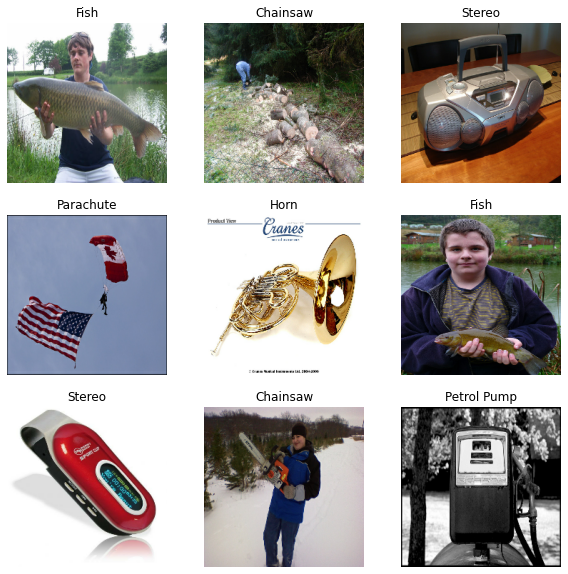

In [3]:
#setting class names
class_names = ["Fish", "Dog", "Stereo", "Chainsaw", "Church", "Horn", "Truck", "Petrol Pump", "Golf Ball", "Parachute"]
#visulisation of the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset2.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) 
    plt.imshow(images[i].numpy().astype("uint8")) 
    plt.title(class_names[labels[i]]) 
    plt.axis("off")

In [4]:
#val_batches = tf.data.experimental.cardinality(val_dataset2)
#test_dataset = val_dataset2.take(val_batches // 5)
#validation_dataset = val_dataset2.skip(val_batches // 5)

#With this above code i split the data into training, validation and testing. However, due to the datasize i decided not to do this split.
#I instead used the validation set to test the accuracy of the model. 

In [4]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset2))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset2))
#checking the number of batches that will be used in model. 

Number of validation batches: 124
Number of train batches: 313


In [6]:
#another way of retreiving the batch size and image size. 
#The 3 is the number of RGB channels.
for image_batch, labels_batch in train_dataset2:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [7]:
#configuring the dataset for improvement in performance
AUTOTUNE = tf.data.AUTOTUNE
#.cache function helps to keep the image data in the disk when its loaded off during model training.
train_ds = train_dataset2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#prefetch overlaps the data during model training.
val_ds = val_dataset2.cache().prefetch(buffer_size=AUTOTUNE)

Data standardization

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
#neural networks work better with a RGB channel value between 0 and 1.

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# showing the new pixel values which are now between 0 and 1
print(np.min(first_image), np.max(first_image))

0.0 1.0


Building model

In [10]:
num_classes = len(class_names)

#putting together the layers of this model. including the 
model = Sequential([
  layers.Rescaling(1./255, input_shape=(224,224, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
#Adam optimizer used to compile this model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
#viewing model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [13]:
len(model.trainable_variables)

10

In [14]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(val_dataset2)

100/100 [==============================] - 512s 4s/step - loss: 2.3048 - accuracy: 0.1010


In [15]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.30
initial accuracy: 0.10


Trainging model

In [16]:
epochs=5 #number of times model will run over training data

#fitting the data to the model and training 
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
313/313 [==============================] - 528s 2s/step - loss: 1.6777 - accuracy: 0.4248 - val_loss: 1.3608 - val_accuracy: 0.5427
Epoch 2/5
313/313 [==============================] - 525s 2s/step - loss: 1.0766 - accuracy: 0.6596 - val_loss: 1.1561 - val_accuracy: 0.6179
Epoch 3/5
313/313 [==============================] - 541s 2s/step - loss: 0.7000 - accuracy: 0.7809 - val_loss: 1.1769 - val_accuracy: 0.6371
Epoch 4/5
313/313 [==============================] - 500s 2s/step - loss: 0.3751 - accuracy: 0.8805 - val_loss: 1.3456 - val_accuracy: 0.6434
Epoch 5/5
313/313 [==============================] - 516s 2s/step - loss: 0.1521 - accuracy: 0.9539 - val_loss: 1.6695 - val_accuracy: 0.6355


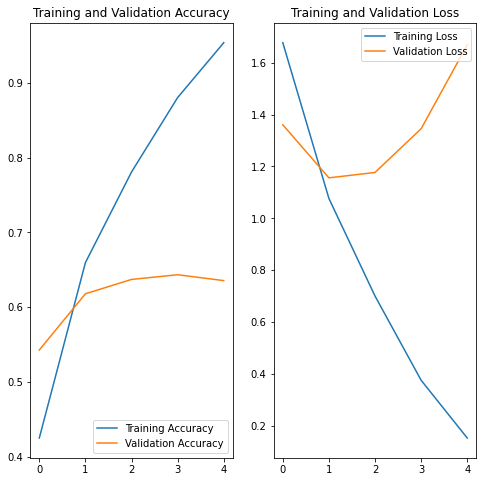

In [17]:
#plotting graph for visulisation of model accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

DATA AUGMENTATION

This is the first technique used to optimize the model above to reduce overfitting 

In [20]:
#augmenting the data so that the model when trained again can be exposed to 
#more variation in the dataset.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

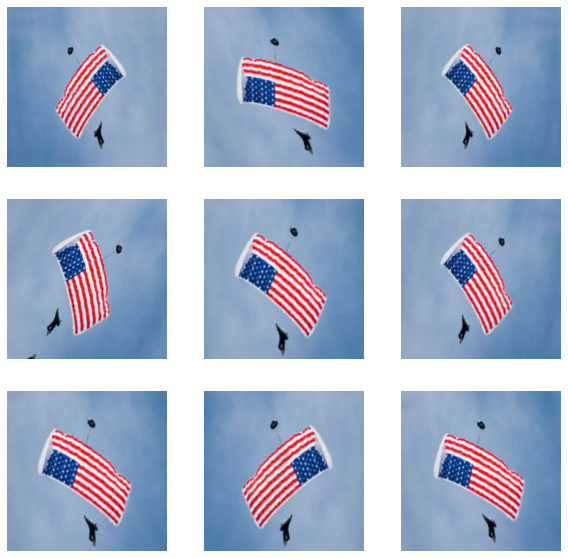

In [22]:
#viewing the result of the data augmentation with one image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1) 
    plt.imshow(augmented_images[0].numpy().astype("uint8")) 
    #plt.title(class_names[labels[i]]) 
    plt.axis("off")

In [23]:
#rebuilding the model with the augmentation applied. Also introducing a dropout layer.
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
#compling the model, again adam optimizer used.
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [28]:
#training the model with 10 epochs.
epochs = 10
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
313/313 [==============================] - 575s 2s/step - loss: 1.0981 - accuracy: 0.6351 - val_loss: 1.1721 - val_accuracy: 0.6188
Epoch 2/10
313/313 [==============================] - 575s 2s/step - loss: 1.0275 - accuracy: 0.6633 - val_loss: 1.2329 - val_accuracy: 0.6025
Epoch 3/10
313/313 [==============================] - 575s 2s/step - loss: 0.9975 - accuracy: 0.6721 - val_loss: 1.1796 - val_accuracy: 0.6399
Epoch 4/10
313/313 [==============================] - 576s 2s/step - loss: 0.9375 - accuracy: 0.6878 - val_loss: 1.2428 - val_accuracy: 0.5886
Epoch 5/10
313/313 [==============================] - 566s 2s/step - loss: 0.8853 - accuracy: 0.7083 - val_loss: 1.1099 - val_accuracy: 0.6431
Epoch 6/10
313/313 [==============================] - 571s 2s/step - loss: 0.8465 - accuracy: 0.7205 - val_loss: 0.9870 - val_accuracy: 0.6947
Epoch 7/10
313/313 [==============================] - 566s 2s/step - loss: 0.7981 - accuracy: 0.7407 - val_loss: 1.0162 - val_accuracy: 0.6821

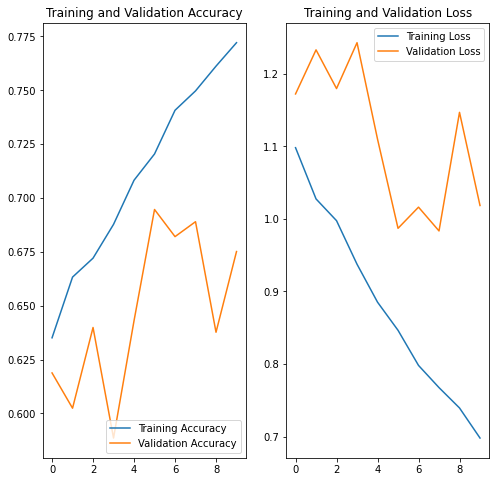

In [29]:
#visualising the optimized models accuracy and loss. 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()